/var/folders/zb/601780_d7mg3ktzvn0smkgzm0000gn/T/ipykernel_96926/420595931.py:7: RuntimeWarning: invalid value encountered in true_divide
  return (1 - (1/r)**i) / (1 - (1/r)**N)
/var/folders/zb/601780_d7mg3ktzvn0smkgzm0000gn/T/ipykernel_96926/420595931.py:7: RuntimeWarning: invalid value encountered in true_divide
  return (1 - (1/r)**i) / (1 - (1/r)**N)
/var/folders/zb/601780_d7mg3ktzvn0smkgzm0000gn/T/ipykernel_96926/420595931.py:7: RuntimeWarning: invalid value encountered in true_divide
  return (1 - (1/r)**i) / (1 - (1/r)**N)


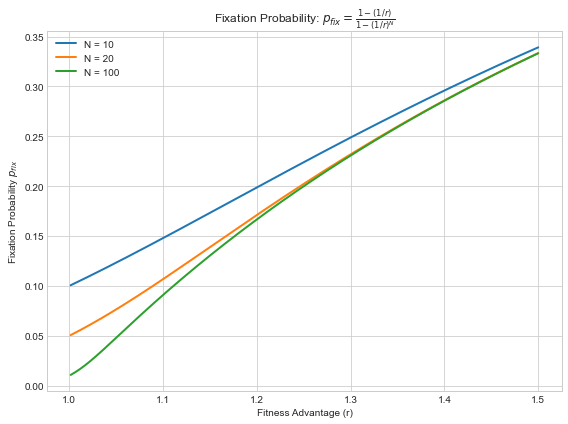

In [9]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('seaborn-whitegrid')

def fixation_probability(r, N, i=1):
    return (1 - (1/r)**i) / (1 - (1/r)**N)

r_values = np.linspace(1.0, 1.5, 300)
N_list = [10, 20, 100]

plt.figure(figsize=(8,6))
for N in N_list:
    p_fix = fixation_probability(r_values, N, i=1)
    plt.plot(r_values, p_fix, lw=2, label=f"N = {N}")
plt.xlabel("Fitness Advantage (r)")
plt.ylabel("Fixation Probability $p_{fix}$")
plt.title(r"Fixation Probability: $p_{fix} = \frac{1 - (1/r)}{1 - (1/r)^N}$")
plt.legend()
plt.tight_layout()
plt.savefig('MoranFixationProbability.pdf', format='pdf')
plt.show()

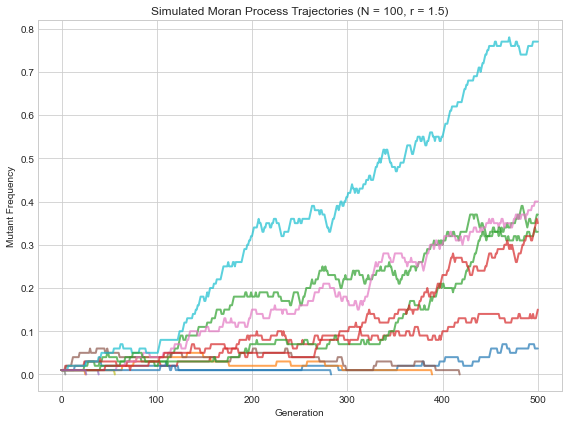

In [13]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('seaborn-whitegrid')

def simulate_moran(N, r, max_steps=500):
    # 初期に1個の mutant (有利変異) から開始
    i = 1
    traj = [i / N]
    for step in range(max_steps):
        if i == 0 or i == N:
            break  # 吸収状態に到達
        # mutant の出生確率 (fitness: r) と wild type (fitness: 1)
        prob_mutant = (r * i) / (r * i + (N - i))
        if np.random.rand() < prob_mutant:
            # mutant reproduces; if death occurs in wild type, mutant count増加
            if np.random.rand() < (N - i)/N:
                i += 1
        else:
            # wild type reproduces; if mutant dies, mutant count減少
            if np.random.rand() < i/N:
                i -= 1
        traj.append(i / N)
    return traj

N = 100
r_val = 1.5
num_simulations = 15

plt.figure(figsize=(8,6))
for _ in range(num_simulations):
    traj = simulate_moran(N, r_val, max_steps=500)
    plt.plot(traj, lw=2, alpha=0.7)
plt.xlabel("Generation")
plt.ylabel("Mutant Frequency")
plt.title(f"Simulated Moran Process Trajectories (N = {N}, r = {r_val})")
plt.grid(True)
plt.tight_layout()
plt.savefig('MoranProcess_Trajectories.pdf', format='pdf')
plt.show()

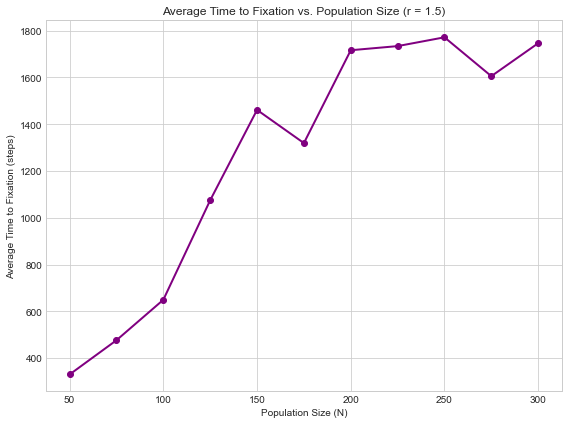

In [15]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('seaborn-whitegrid')

def simulate_moran_fixation_time(N, r, max_steps=5000):
    i = 1
    steps = 0
    while i != 0 and i != N and steps < max_steps:
        steps += 1
        prob_mutant = (r * i) / (r * i + (N - i))
        if np.random.rand() < prob_mutant:
            if np.random.rand() < (N - i) / N:
                i += 1
        else:
            if np.random.rand() < i / N:
                i -= 1
    return steps

r_val = 1.5
N_values = np.arange(50, 301, 25)
num_sim = 200
avg_fixation_times = []

for N in N_values:
    times = [simulate_moran_fixation_time(N, r_val) for _ in range(num_sim)]
    avg_fixation_times.append(np.mean(times))

plt.figure(figsize=(8,6))
plt.plot(N_values, avg_fixation_times, 'o-', lw=2, color='purple')
plt.xlabel("Population Size (N)")
plt.ylabel("Average Time to Fixation (steps)")
plt.title(f"Average Time to Fixation vs. Population Size (r = {r_val})")
plt.grid(True)
plt.tight_layout()
plt.savefig('MoranProcess_FixationTime.pdf', format='pdf')
plt.show()

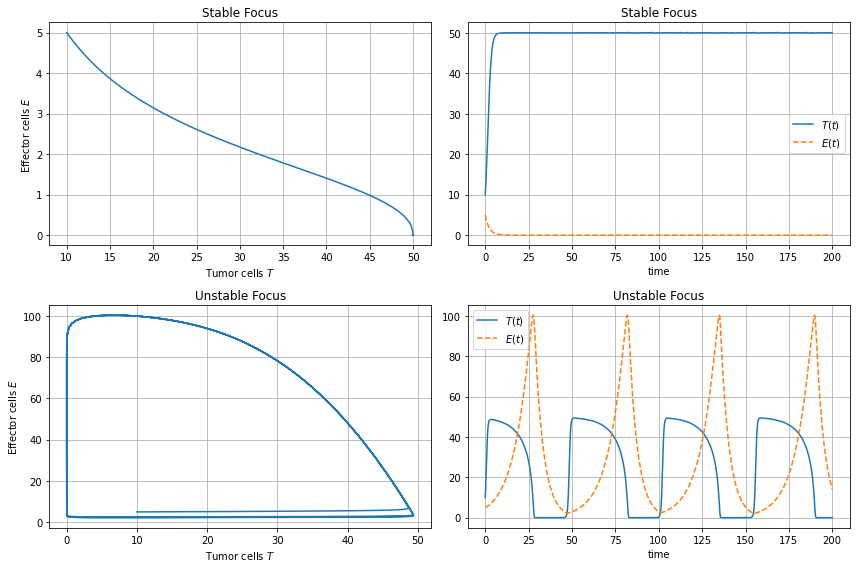

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

def rosenzweig_macarthur(t, z, r, K, p, h, e, d):
    """
    Rosenzweig–MacArthur tumor–immune / predator–prey model:
      dT/dt = r T (1 - T/K) - p T E / (T + h)
      dE/dt = e p T E / (T + h) - d E
    """
    T, E = z
    dT = r * T * (1 - T / K) - p * T * E / (T + h)
    dE = e * p * T * E / (T + h) - d * E
    return [dT, dE]

# Parameter sets for two regimes
cases = [
    # Stable focus: damped oscillations converging to equilibrium
    {
        'r': 1.0,    # tumor grow rate
        'K': 50.0,   # carrying capacity
        'p': 0.2,    # predation / immune kill rate
        'h': 20.0,   # half‐saturation constant
        'e': 0.5,    # conversion efficiency
        'd': 0.5,    # immune cell decay rate
        'title': 'Stable Focus'
    },
    # Unstable focus: oscillations grow away from equilibrium
    {
        'r': 2.5,
        'K': 50.0,
        'p': 0.5,
        'h': 5.0,
        'e': 0.7,
        'd': 0.2,
        'title': 'Unstable Focus'
    }
]

# Time span and initial condition
t_span = (0, 200)
t_eval = np.linspace(*t_span, 2000)
z0 = [10.0, 5.0]  # initial (T, E)

# Prepare figure: 2 rows × {phase, time series}
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

for i, params in enumerate(cases):
    ax_phase = axes[i, 0]
    ax_time  = axes[i, 1]

    # Solve ODE
    sol = solve_ivp(
        rosenzweig_macarthur,
        t_span, z0,
        args=(params['r'], params['K'], params['p'],
              params['h'], params['e'], params['d']),
        t_eval=t_eval
    )
    T, E = sol.y

    # Phase plane trajectory
    ax_phase.plot(T, E, color='C0', lw=1.5)
    ax_phase.set_title(params['title'])
    ax_phase.set_xlabel('Tumor cells $T$')
    ax_phase.set_ylabel('Effector cells $E$')
    ax_phase.grid(True)

    # Time series of T and E
    ax_time.plot(sol.t, T, color='C0', label='$T(t)$')
    ax_time.plot(sol.t, E, color='C1', linestyle='--', label='$E(t)$')
    ax_time.set_title(params['title'])
    ax_time.set_xlabel('time')
    ax_time.legend()
    ax_time.grid(True)

plt.tight_layout()
plt.show()

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Tumor–immune Rosenzweig–MacArthur model
def dT_dt(T, E, r, K, p, h, e, d):
    return r * T * (1 - T / K) - p * T * E / (T + h)

def dE_dt(T, E, r, K, p, h, e, d):
    return e * p * T * E / (T + h) - d * E

# Parameter sets for two regimes
cases = [
    {
        'r': 1.0, 'K': 50.0, 'p': 0.2, 'h': 20.0, 'e': 0.5, 'd': 0.5,
        'title': 'Stable Focus'
    },
    {
        'r': 2.5, 'K': 50.0, 'p': 0.5, 'h': 5.0, 'e': 0.7, 'd': 0.2,
        'title': 'Unstable Focus'
    }
]

# Domain for phase plane
T_min, T_max = 0, 80
E_min, E_max = 0, 80
T_vals = np.linspace(T_min, T_max, 30)
E_vals = np.linspace(E_min, E_max, 30)
T_grid, E_grid = np.meshgrid(T_vals, E_vals)
T_line = np.linspace(T_min, T_max, 400)

# Phase plane plots
fig_phase, axs_phase = plt.subplots(1, 2, figsize=(12, 5))
for ax, params in zip(axs_phase, cases):
    r, K, p, h, e, d, title = (params[k] for k in ('r','K','p','h','e','d','title'))
    # Vector field
    U = dT_dt(T_grid, E_grid, r, K, p, h, e, d)
    V = dE_dt(T_grid, E_grid, r, K, p, h, e, d)
    ax.streamplot(
        T_grid, E_grid, U, V,
        color='gray', density=1.2, linewidth=1.0, arrowsize=1.5
    )

    # Nullcline dT/dt = 0: E = r*(1 - T/K)*(T + h)/p
    E_null_T = r * (1 - T_line/K) * (T_line + h) / p
    ax.plot(T_line, E_null_T, 'r--', label='dT/dt = 0')

    # Nullcline dE/dt = 0: T = d*h/(e*p - d) (if e*p > d)
    if e*p > d:
        T_null_E = d * h / (e * p - d)
        ax.axvline(T_null_E, color='b', linestyle='--', label='dE/dt = 0')
    else:
        T_null_E = None

    # Equilibria
    # trivial
    ax.plot(0, 0, 'ko')
    # nontrivial (intersection of nullclines)
    if T_null_E is not None:
        T_star = T_null_E
        E_star = r * (1 - T_star/K) * (T_star + h) / p
        ax.plot(T_star, E_star, 'ko')

    # Labels, limits, grid
    ax.set_title(title)
    ax.set_xlabel('Tumor cells $T$')
    ax.set_ylabel('Effector cells $E$')
    ax.set_xlim(T_min, T_max)
    ax.set_ylim(E_min, E_max)
    ax.legend(loc='upper right')
    ax.grid(True)

fig_phase.tight_layout()
fig_phase.savefig('Tumor_Immune_Phase.pdf', format='pdf')
plt.close(fig_phase)

# Time series plots
fig_time, axs_time = plt.subplots(1, 2, figsize=(12, 5))
t_span = (0, 200)
t_eval = np.linspace(*t_span, 2000)
z0 = [10.0, 5.0]

for ax, params in zip(axs_time, cases):
    r, K, p, h, e, d, title = (params[k] for k in ('r','K','p','h','e','d','title'))
    sol = solve_ivp(
        lambda t, z: [
            dT_dt(z[0], z[1], r, K, p, h, e, d),
            dE_dt(z[0], z[1], r, K, p, h, e, d)
        ],
        t_span, z0, t_eval=t_eval
    )
    T, E = sol.y
    ax.plot(sol.t, T, label='$T(t)$')
    ax.plot(sol.t, E, '--', label='$E(t)$')
    ax.set_title(title)
    ax.set_xlabel('time')
    ax.legend()
    ax.grid(True)

fig_time.tight_layout()
fig_time.savefig('Tumor_Immune_TimeSeries.pdf', format='pdf')
plt.close(fig_time)